In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from glob import glob

In [2]:
def read_daily_report(file_name):
    with open(file_name, 'rt') as f:
        header = f.readline(), f.readline(), f.readline()
    day, _, line, _, _, station_id, _ = header[0].split(';')
    gate_names = header[1].split(';')[1:-1]
    column_names = [name + ['_in', '_out'][i % 2] for i, name in enumerate(gate_names)] + ['LF']
    
    station_daily_usage = pd.read_csv(file_name, skiprows=3, delimiter=';', names = column_names, index_col=0)
    station_daily_usage.drop(labels='Suma', axis='index', inplace=True)
    station_daily_usage.drop(labels='LF', axis='columns', inplace=True)
    station_daily_usage.index = pd.to_datetime([day + ' ' + h for h in station_daily_usage.index])
    station_daily_usage.index.name = 'time'
    
    return day, station_id, station_daily_usage


def aggregte_gates(station_daily_usage):
    gates_in = station_daily_usage[[c for c in station_daily_usage.columns if 'in' in c]]
    gates_out = station_daily_usage[[c for c in station_daily_usage.columns if 'out' in c]]

    station_daily_usage['total_in'] = gates_in.sum(axis='columns')
    station_daily_usage['total_out'] = gates_out.sum(axis='columns')
    
    return station_daily_usage


def aggregate_hours(station_daily_usage, day):
    round_hours = pd.date_range(day, periods=24, freq='H')
    time_buckets = pd.to_datetime(
        pd.cut(
            x = pd.to_numeric(station_daily_usage.index), 
            bins = pd.to_numeric(round_hours), 
            labels = round_hours[:-1]
        )
    )
    station_daily_usage['hour'] = time_buckets
    station_daily_usage = station_daily_usage[['total_in', 'total_out', 'hour']].groupby('hour').sum()
    
    return station_daily_usage

In [3]:
def read_report_hourly(file_name):
    day, station_id, station_daily_usage = read_daily_report(file_name)
    station_daily_usage = aggregte_gates(station_daily_usage)
    station_daily_usage = aggregate_hours(station_daily_usage, day)
    return station_id, station_daily_usage


def read_report_daily(file_name):
    day, station_id, station_daily_usage = read_daily_report(file_name)
    station_daily_usage = aggregte_gates(station_daily_usage)
    station_daily_usage = pd.DataFrame({day: station_daily_usage[['total_in', 'total_out']].sum(axis='index')}).T
    return station_id, station_daily_usage

In [4]:
days = [read_report_daily(fn) for fn in glob(r"../data/A18/2020/**/*.txt")]
station_id, days = zip(*days)
station_id = station_id[0]
s = pd.concat(days)

s['total'] = s.total_in + s.total_out
s.index = pd.to_datetime(s.index)

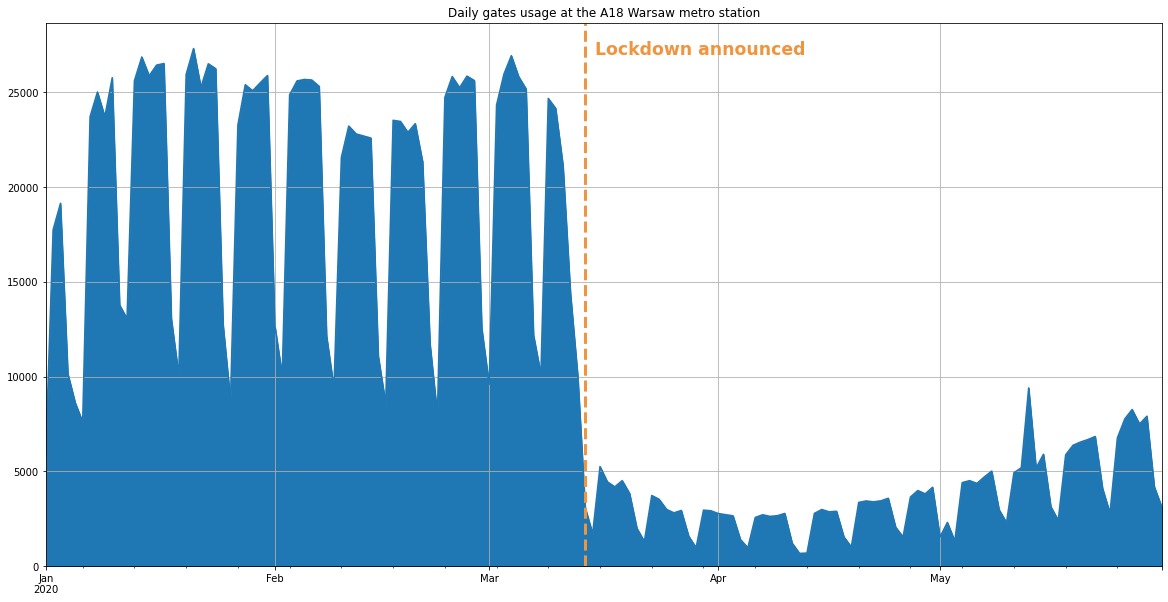

In [5]:
s.total.plot.area(figsize=(20,10), title='Daily gates usage at the %s Warsaw metro station' % station_id, grid=True)
plt.axvline(x='2020-03-14', c='#F0943E', ls='--', lw=3, alpha=1.)
plt.annotate('Lockdown announced', 
             xy=('2020-03-14', 27000), 
             textcoords=('offset pixels', 'offset pixels'), 
             xytext=(10, 0),
             size='xx-large',
             weight='heavy',
             c='#F0943E'
             );